In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [2]:
data_dir_visualize_2d = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\ANN Model\2D Data"
bt_folders_visualize_2d = ['B.T. 340']

In [3]:
data_dir_visualize_3d = r"S:\Nit Durgapur\College 4th Sem\JU Internship\Fins Heat Prediction\ANN Model\3D Data"
z_planes_visualize_3d = ['Z = + 0 mm', 'Z = + 100 mm', 'Z = + 175 mm', 'Z = + 275 mm', 'Z = + 375 mm', 'Z = + 475 mm']

In [4]:
all_temp_data_2d = [] # Empty list to hold all temperature data

# Loop over folders
for folder in bt_folders_visualize_2d:
    folder_path_2d = os.path.join(data_dir_visualize_2d, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path_2d):
        if filename.lower().endswith('temp.csv'):
            file_path_2d = os.path.join(folder_path_2d, filename)
            df_visualize_2d = pd.read_csv(file_path_2d)
            df_visualize_2d.columns = ['x', 'y', 'z', 'Temperature'] 
            df_visualize_2d['BT'] = int(folder.split('.')[-1]) # Creating the B.T. column
            all_temp_data_2d.append(df_visualize_2d)

# Combine all
df_visualize_2d = pd.concat(all_temp_data_2d, ignore_index = True)

In [5]:
df_visualize_2d.head

<bound method NDFrame.head of                x         y  z  Temperature   BT
0       0.096000  0.180003  0        300.0  340
1       0.096002  0.181001  0        300.0  340
2       0.095002  0.181004  0        300.0  340
3       0.094999  0.180003  0        300.0  340
4       0.095999  0.182005  0        300.0  340
...          ...       ... ..          ...  ...
347749  0.000000  0.297000  0        300.0  340
347750  0.000000  0.298000  0        300.0  340
347751  0.000000  0.299000  0        300.0  340
347752  0.000000  0.300000  0        300.0  340
347753  0.001000  0.300000  0        300.0  340

[347754 rows x 5 columns]>

In [6]:
all_temp_data_3d = [] # Empty list to hold all temperature data

# Loop over folders
for folder in z_planes_visualize_3d:
    folder_path_3d = os.path.join(data_dir_visualize_3d, folder)
    
    # Search for temp.csv file inside the folder
    for filename in os.listdir(folder_path_3d):
        if filename.lower().endswith('temp.csv'):
            file_path_3d = os.path.join(folder_path_3d, filename)
            df_visualize_3d = pd.read_csv(file_path_3d)
            df_visualize_3d.columns = ['x', 'y', 'z', 'Temperature']
            df_visualize_3d['Z'] = int(folder.split('+')[1].split('mm')[0].strip())  # Creating the B.T. column
            all_temp_data_3d.append(df_visualize_3d)

# Combine all
df_visualize_3d = pd.concat(all_temp_data_3d, ignore_index = True)
df_visualize_3d = df_visualize_3d[['x', 'y', 'Z', 'Temperature']]

In [7]:
df_visualize_3d

,x,y,Z,Temperature
0,0.180000,0.020000,0,340.074
1,0.190000,0.020000,0,340.069
2,0.190000,0.030000,0,340.069
3,0.180000,0.030000,0,340.070
4,0.180000,0.010000,0,340.073
...,...,...,...,...
28257,-0.056509,0.089529,475,300.000
28258,0.258965,0.084843,475,300.000
28259,0.246018,0.095577,475,300.000
28260,-0.092987,0.114705,475,300.000


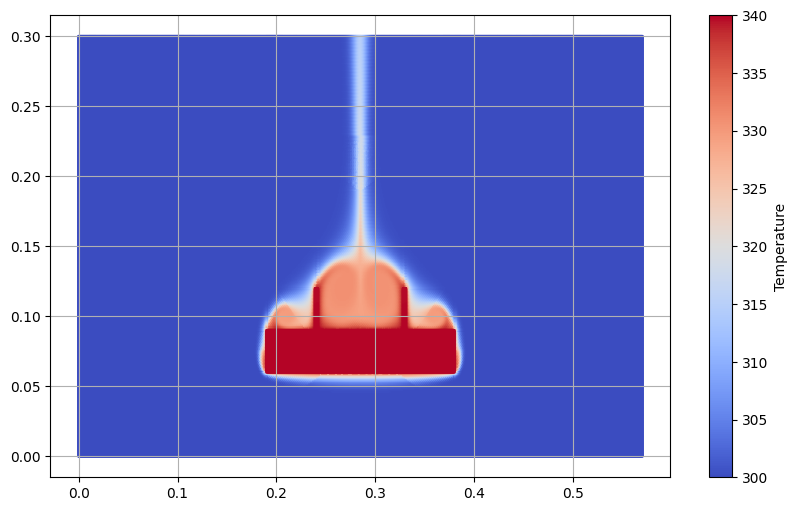

In [8]:
bt_value_2d = 340
df_bt = df_visualize_2d[df_visualize_2d['BT'] == bt_value_2d]

plt.figure(figsize = (10, 6))
plt.scatter(df_bt['x'], df_bt['y'], c = df_bt['Temperature'], cmap = 'coolwarm', s = 1)
plt.colorbar(label = 'Temperature')
plt.grid(True)
plt.show()

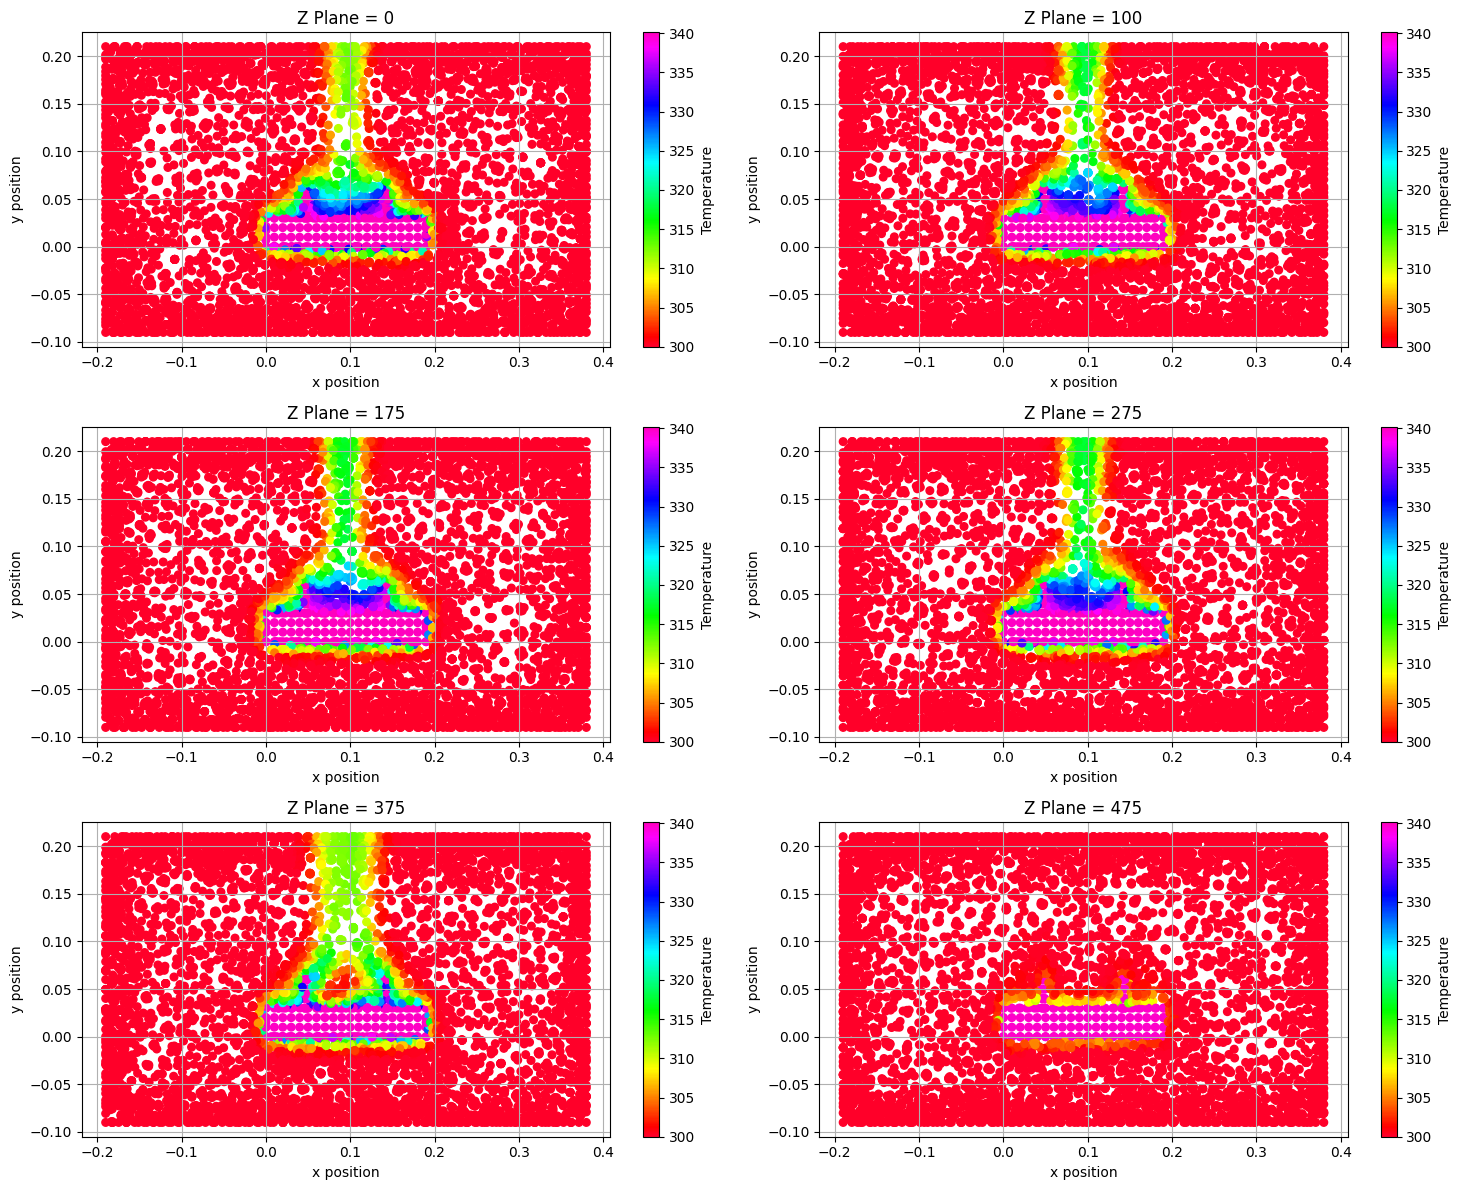

In [9]:
# Get unique boundary conditions sorted
unique_bcs = sorted(df_visualize_3d['Z'].unique())

# Set up subplots
n_cols = 2
n_rows = 3

fig, axes = plt.subplots(n_rows, n_cols, figsize = (15, 12))
axes = axes.flatten() # Flatten the 2D array of axes to 1D array

# Loop through B.T.s and plot
for idx, z_plane in enumerate(unique_bcs):
    df_bt = df_visualize_3d[df_visualize_3d['Z'] == z_plane]
    
    ax = axes[idx]
    scatter = ax.scatter(
        df_bt['x'], 
        df_bt['y'], 
        c = df_bt['Temperature'], 
        cmap = 'gist_rainbow', 
        s = 30, 
        vmin = df_visualize_3d['Temperature'].min(), 
        vmax = df_visualize_3d['Temperature'].max()
    )
    ax.set_title(f'Z Plane = {z_plane}')
    ax.set_xlabel('x position')
    ax.set_ylabel('y position')
    ax.grid(True)
    cbar = fig.colorbar(scatter, ax = ax)
    cbar.set_label('Temperature')

plt.tight_layout()
plt.show()

## Inter or Extra Polation

### Up-Sampling the 3D Data Points to match the number of 2D Data Points

In [10]:
from scipy.spatial import cKDTree

In [11]:
# 1. Prepare data
df_3d = df_visualize_3d[df_visualize_3d['Z'] == 0][['x', 'y', 'Temperature']].dropna()
df_2d = df_visualize_2d[['x', 'y']].dropna()

In [12]:
# 2. Convert to numpy arrays
points_3d = df_3d[['x', 'y']].values
values_3d = df_3d['Temperature'].values
points_2d = df_2d[['x', 'y']].values

In [13]:
# 3. IDW parameters
k_neighbors = 10 # Number of nearest neighbors to consider
power = 2 # Power parameter (higher = more influence to closer points)

In [14]:
# 4. Build KDTree for fast neighbor searches
tree = cKDTree(points_3d)

In [15]:
# 5. Find distances and indices of k-nearest 3D points for each 2D point
distances, indices = tree.query(points_2d, k = k_neighbors)

In [16]:
# 6. Calculate weights (inverse distance^power)
weights = 1.0 / (distances**power + 1e-9) # Small epsilon to avoid division by zero
weights /= weights.sum(axis = 1)[ :, np.newaxis] # Normalize weights

In [17]:
# 7. Compute weighted temperature values
temp_interpolated = np.sum(values_3d[indices] * weights, axis = 1)

In [18]:
# 8. Create upsampled DataFrame
df_upsampled = pd.DataFrame({
    'X': points_2d[ :, 0],
    'Y': points_2d[ :, 1],
    'Z': 0,
    'Temperature': temp_interpolated
})

In [19]:
# 9. Save results
df_upsampled.to_csv('S:\\Nit Durgapur\\College 4th Sem\\JU Internship\\Fins Heat Prediction\\ANN Model\\3D Up-Sampled Data\\z0_upsample_interpolated_data.csv', index = False)

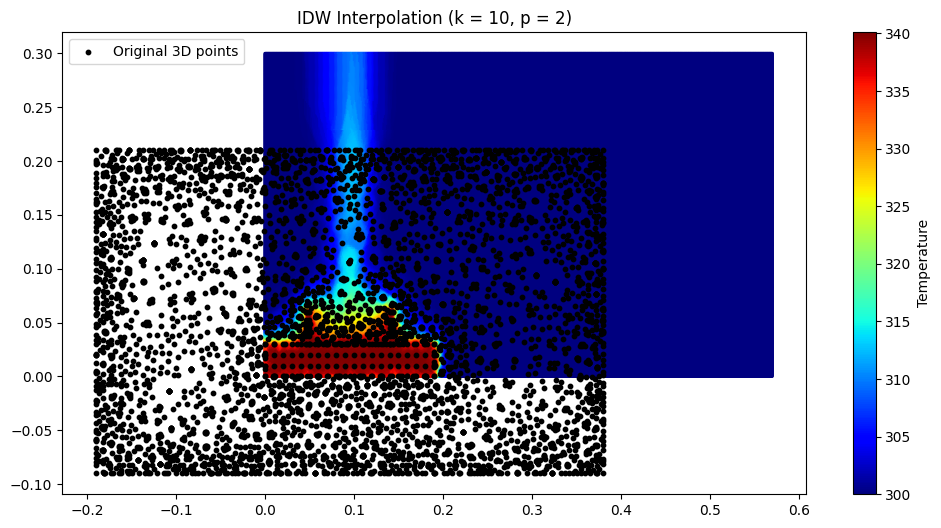

In [20]:
import matplotlib.pyplot as plt
plt.figure(figsize = (12, 6))
plt.scatter(df_upsampled['X'], df_upsampled['Y'], c = df_upsampled['Temperature'], s = 1, cmap = 'jet')
plt.colorbar(label = 'Temperature')
plt.scatter(points_3d[ :, 0], points_3d[ :, 1], c = 'black', s = 10, label = 'Original 3D points')
plt.title(f'IDW Interpolation (k = {k_neighbors}, p = {power})')
plt.legend()
plt.show()

In [21]:
z0_upsample_interpolated = pd.read_csv('S:\\Nit Durgapur\\College 4th Sem\\JU Internship\\Fins Heat Prediction\\ANN Model\\3D Up-Sampled Data\\z0_upsample_interpolated_data.csv')

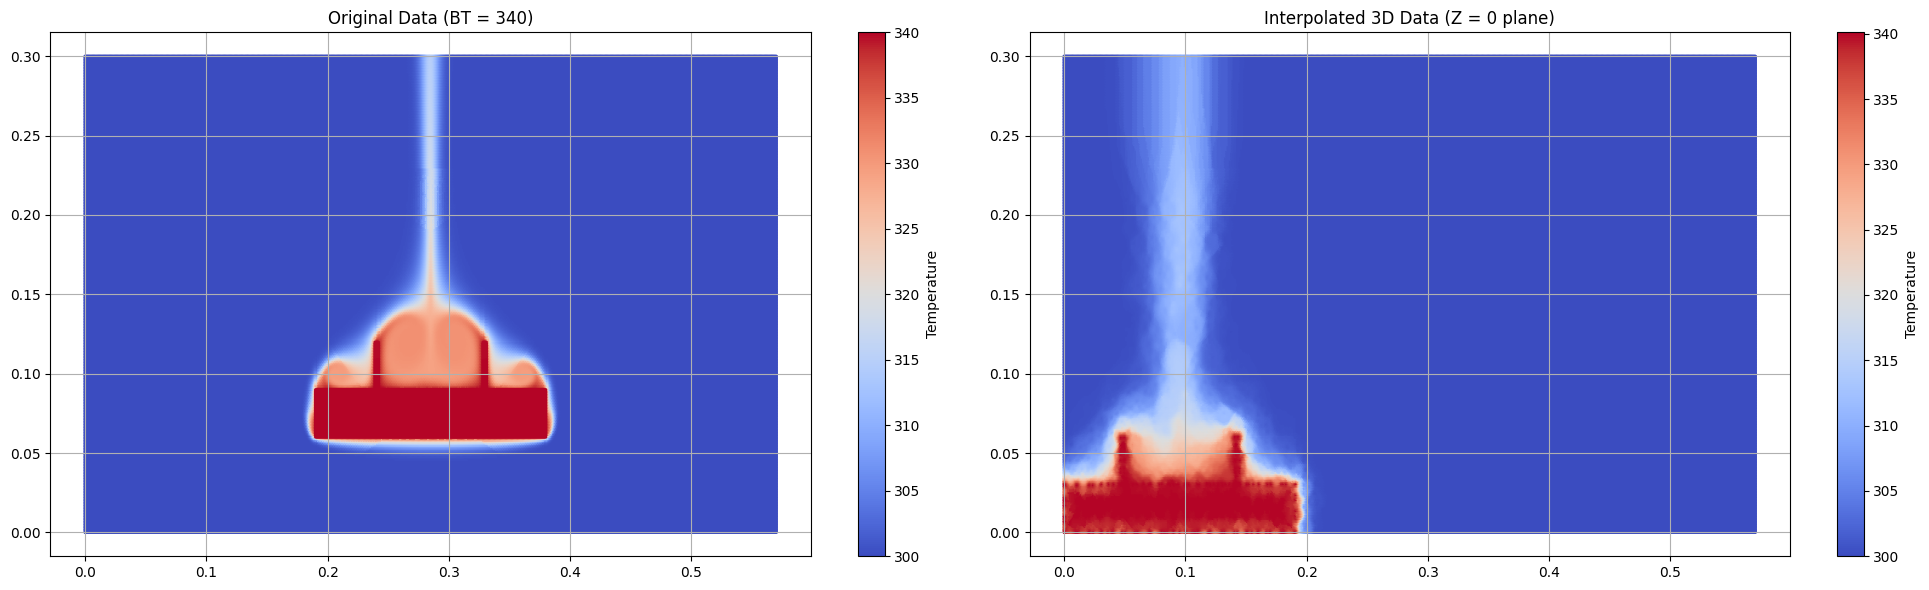

In [22]:
bt_value_2d = 340
df_bt = df_visualize_2d[df_visualize_2d['BT'] == bt_value_2d]

fig, (ax1, ax2) = plt.subplots(1, 2, figsize = (20, 6))

scatter1 = ax1.scatter(df_bt['x'], df_bt['y'], c = df_bt['Temperature'], cmap = 'coolwarm', s = 1)
fig.colorbar(scatter1, ax = ax1, label = 'Temperature')
ax1.grid(True)
ax1.set_title(f'Original Data (BT = {bt_value_2d})')

scatter2 = ax2.scatter(
    z0_upsample_interpolated['X'], 
    z0_upsample_interpolated['Y'], 
    c = z0_upsample_interpolated['Temperature'], 
    cmap = 'coolwarm', 
    s = 1,
    vmin = min(df_bt['Temperature'].min(), z0_upsample_interpolated['Temperature'].min()), 
    vmax = max(df_bt['Temperature'].max(), z0_upsample_interpolated['Temperature'].max())
)
fig.colorbar(scatter2, ax = ax2, label = 'Temperature')
ax2.grid(True)
ax2.set_title('Interpolated 3D Data (Z = 0 plane)')

plt.tight_layout()
plt.show()

### Down-Sampling the 2D Data Points to match the number of 3D Data Points

In [23]:
from sklearn.cluster import KMeans
from scipy.spatial import cKDTree
from sklearn.metrics import pairwise_distances_argmin_min

In [24]:
# 1. Get target count from 3D data (Z = 0 plane)
target_count = len(df_visualize_3d[df_visualize_3d['Z'] == 0])

In [25]:
# 2. Prepare 2D data (coordinates and temperature)
coords_2d = df_visualize_2d[['x', 'y']].values
temp_2d = df_visualize_2d['Temperature'].values

In [26]:
# 3. Perform K-means clustering
kmeans = KMeans(n_clusters = target_count, random_state = 42, n_init = 10)
kmeans.fit(coords_2d)

KMeans(n_clusters=4798, n_init=10, random_state=42)

In [27]:
# 4. Find nearest original points to cluster centers
closest_indices, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, coords_2d)

In [28]:
# 5. Create downsampled DataFrame (direct nearest-neighbor assignment)
df_2d_downsampled = df_visualize_2d.iloc[closest_indices].copy()

In [29]:
# Advanced Temperature Interpolation (For smoother temperature preservation)
# 6. Build KDTree for temperature interpolation
tree = cKDTree(coords_2d)

In [30]:
# 7. For each cluster center, find k nearest points and average their temperatures
k_temp = 5  # Number of neighbors for temperature interpolation
distances, indices = tree.query(kmeans.cluster_centers_, k = k_temp)

In [31]:
# 8. Calculate inverse distance weighted temperature
power = 2  # Power parameter for IDW
weights = 1.0 / (distances**power + 1e-9)
weights /= weights.sum(axis = 1)[ :, np.newaxis]

In [32]:
# 9. Compute interpolated temperatures
interp_temps = np.sum(temp_2d[indices] * weights, axis = 1)

In [33]:
# 10. Assign interpolated temperatures
df_2d_downsampled['Temperature'] = interp_temps

In [34]:
df_2d_downsampled.to_csv('S:\\Nit Durgapur\\College 4th Sem\\JU Internship\\Fins Heat Prediction\\ANN Model\\2D Down-Sampled Data\\2d_downsample_temperature.csv', index = False)

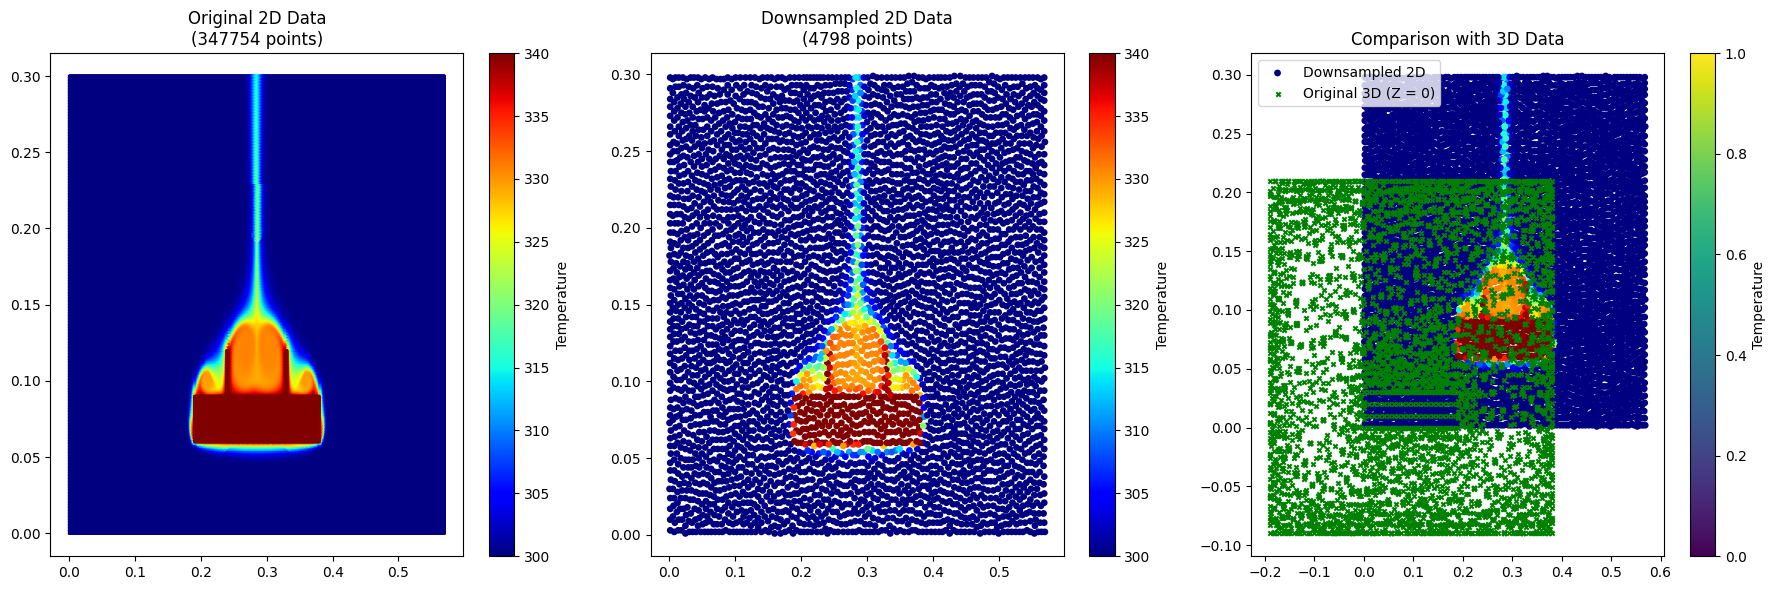

In [35]:
plt.figure(figsize=(18, 6))

# Original 2D Data
plt.subplot(1, 3, 1)
plt.scatter(df_visualize_2d['x'], df_visualize_2d['y'], c = df_visualize_2d['Temperature'], s = 1, cmap = 'jet')
plt.colorbar(label = 'Temperature')
plt.title(f'Original 2D Data\n({len(df_visualize_2d)} points)')

# Downsampled Points
plt.subplot(1, 3, 2)
plt.scatter(df_2d_downsampled['x'], df_2d_downsampled['y'],  c = df_2d_downsampled['Temperature'], s = 15, cmap = 'jet')
plt.colorbar(label = 'Temperature')
plt.title(f'Downsampled 2D Data\n({target_count} points)')

# Comparison with 3D Points
plt.subplot(1, 3, 3)
plt.scatter(df_2d_downsampled['x'], df_2d_downsampled['y'], c = df_2d_downsampled['Temperature'], s = 15, cmap = 'jet', label = 'Downsampled 2D')
plt.scatter(points_3d[ 0:, 0], points_3d[ :, 1], c = 'green', s = 10, marker = 'x', label = 'Original 3D (Z = 0)')
plt.colorbar(label = 'Temperature')
plt.legend()
plt.title('Comparison with 3D Data')

plt.tight_layout()
plt.show()

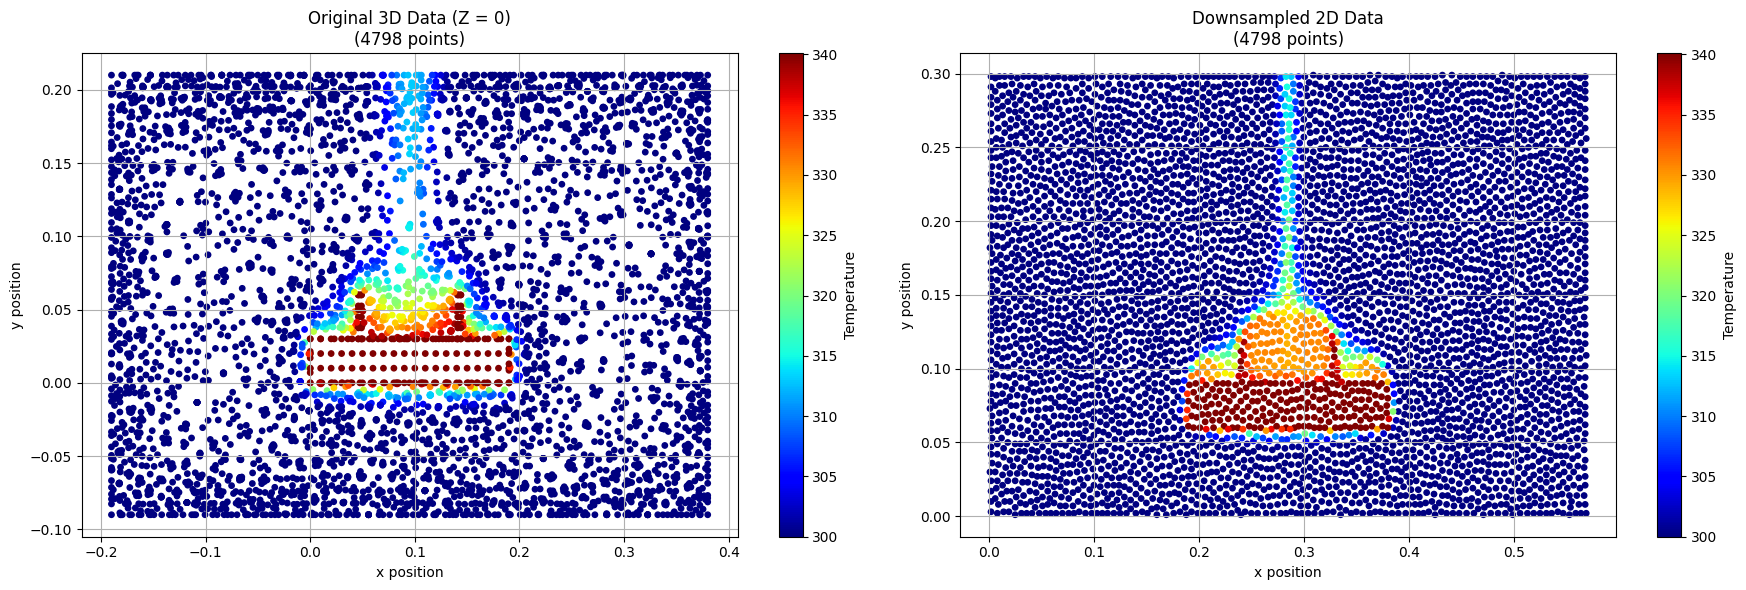

In [ ]:
plt.figure(figsize = (18, 6))

# Original 3D Data
plt.subplot(1, 2, 1)
df_3d_z0 = df_visualize_3d[df_visualize_3d['Z'] == 0]
plt.scatter(df_3d_z0['x'], 
            df_3d_z0['y'], 
            c = df_3d_z0['Temperature'], 
            s = 15, 
            cmap = 'jet',
            vmin = df_visualize_3d['Temperature'].min(),
            vmax = df_visualize_3d['Temperature'].max()
            )
plt.colorbar(label = 'Temperature')
plt.title(f'Original 3D Data (Z = 0)\n({len(df_3d_z0)} points)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)

# Downsampled 2D Points
plt.subplot(1, 2, 2)
plt.scatter(df_2d_downsampled['x'], 
            df_2d_downsampled['y'],  
            c = df_2d_downsampled['Temperature'], 
            s = 15, 
            cmap = 'jet',
            vmin = df_visualize_3d['Temperature'].min(),
            vmax = df_visualize_3d['Temperature'].max())
plt.colorbar(label = 'Temperature')
plt.title(f'Downsampled 2D Data\n({len(df_2d_downsampled)} points)')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)

plt.tight_layout()
plt.show()

In [37]:
from scipy.interpolate import griddata

In [38]:
# 1. Extract original 3D (Z = 0) coordinates and temperatures
df_3d_z0 = df_visualize_3d[df_visualize_3d['Z'] == 0]
points_3d = df_3d_z0[['x', 'y']].values
temps_3d = df_3d_z0['Temperature'].values

In [39]:
# 2. Get target (uniform) coordinates from downsampled 2D
target_points = df_2d_downsampled[['x', 'y']].values

In [40]:
# 3. Interpolate temperatures from 3D data to the 2D grid
interpolated_temps = griddata(points_3d, temps_3d, target_points, method = 'cubic')

In [41]:
# Optional fallback for any NaNs due to extrapolation
nan_indices = np.isnan(interpolated_temps)
if np.any(nan_indices):
    interpolated_temps[nan_indices] = griddata(points_3d, temps_3d, target_points[nan_indices], method = 'nearest')

In [42]:
# 4. Create new DataFrame to store interpolated 3D data with 2D coordinates
df_3d_interpolated_to_2d = df_2d_downsampled[['x', 'y']].copy()
df_3d_interpolated_to_2d['Temperature'] = interpolated_temps

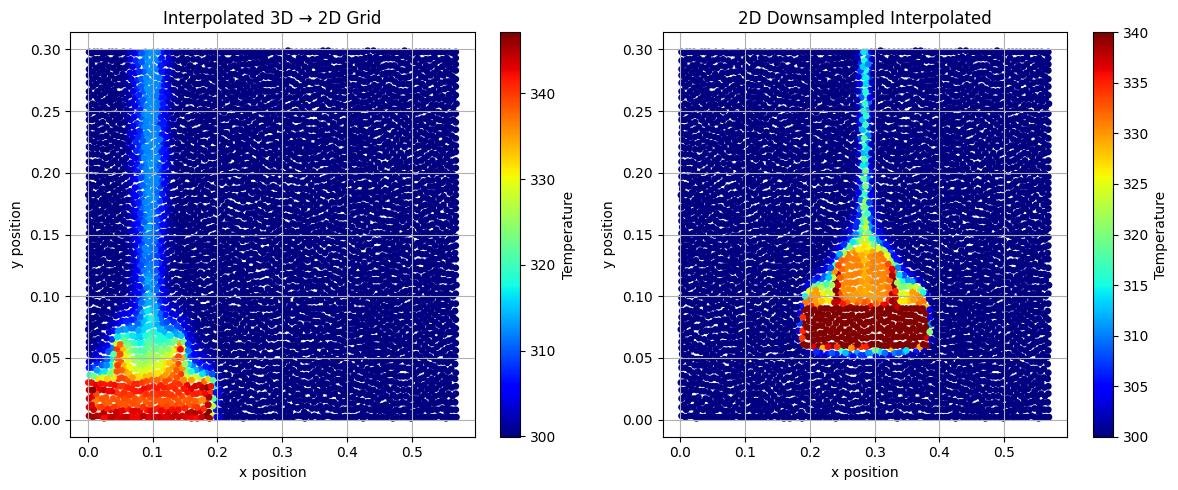

In [ ]:
plt.figure(figsize = (12, 5))

# Interpolated 3D data to 2D grid
plt.subplot(1, 2, 1)
plt.scatter(df_3d_interpolated_to_2d['x'], df_3d_interpolated_to_2d['y'], c = df_3d_interpolated_to_2d['Temperature'], cmap = 'jet', s = 15)
plt.colorbar(label = 'Temperature')
plt.title('Interpolated 3D on 2D Grid')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)

# Original 2D downsampled
plt.subplot(1, 2, 2)
plt.scatter(df_2d_downsampled['x'], df_2d_downsampled['y'], c = df_2d_downsampled['Temperature'], cmap = 'jet', s = 15)
plt.colorbar(label='Temperature')
plt.title('2D Downsampled Interpolated')
plt.xlabel('x position')
plt.ylabel('y position')
plt.grid(True)

plt.tight_layout()
plt.show()

In [44]:
df_3d_interpolated_to_2d.to_csv("S:\\Nit Durgapur\\College 4th Sem\\JU Internship\\Fins Heat Prediction\\ANN Model\\3D Exact Data\\3d_to_2d_exact_data.csv", index = False)